# Общий финансовый анализ на Python (Часть 1)
> General Financial Analysis in Python (Part 1)

- toc: true
- branch: master
- badges: true
- comments: true
- author: Zmey56
- categories: [english, machine learning, algotrading]

В прошлой статье рассмотрено как можно получить информацию по финансовым инструментам. Дальше будет опубликовано несколько статей о том, что первоначально можно делать с полученными данными, как проводить анализ и составлять стратегию. Материалы составлены на основании публикаций в иностранных источниках и курсах на одной из онлайн платформ.

В этой статье будет рассмотрено, как рассчитывать доходность, волатильность и построить один из основных индикаторов.

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

sber = yf.download('SBER.ME','2016-01-01')

[*********************100%***********************]  1 of 1 completed


**Доходность**

Данная величина представляет собой процентное изменение стоимости акции за один торговый день. Оно не учитывает дивиденды и комиссии. Его легко рассчитать используя функцию pct_change () из пакета Pandas.

Как правило используют лог доходность, так как она позволяет лучше понять и исследовать изменения с течением времени.

In [2]:
# Скорректированая цена закрытия`
daily_close = sber[['Adj Close']]

# Дневная доходность
daily_pct_change = daily_close.pct_change()

# Заменить NA значения на 0
daily_pct_change.fillna(0, inplace=True)

print(daily_pct_change.head())

# Дневная лог доходность
daily_log_returns = np.log(daily_close.pct_change()+1)

print(daily_log_returns.head())

            Adj Close
Date                 
2016-01-04   0.000000
2016-01-05   0.008979
2016-01-06  -0.020629
2016-01-11  -0.060093
2016-01-12   0.007470
            Adj Close
Date                 
2016-01-04        NaN
2016-01-05   0.008939
2016-01-06  -0.020845
2016-01-11  -0.061974
2016-01-12   0.007442


Чтобы из полученных данных узнать недельную и/или месячную доходность, используют функцию resample().

In [3]:
# Взять у `sber` значения за последний рабочий день месяца
monthly = sber.resample('BM').apply(lambda x: x[-1])

# Месячная доходность
print(monthly.pct_change().tail())

# Пересчитать `sber` по кварталам и взять среднее значение за квартал
quarter = sber.resample("4M").mean()

# Квартальную доходность
print(quarter.pct_change().tail())

                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2021-06-30 -0.010055 -0.018202 -0.017745 -0.015593  -0.015593  0.363875
2021-07-30 -0.012117 -0.000782 -0.007253  0.001604   0.001604  0.589072
2021-08-31  0.086022  0.077640  0.086870  0.072213   0.072213 -0.344803
2021-09-30  0.004505  0.035464  0.006936  0.033522   0.033522  1.449116
2021-10-29  0.145282  0.105815  0.123980  0.093531   0.093531 -0.536555
                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2020-09-30  0.056380  0.052326  0.063663  0.059189   0.231932 -0.288569
2021-01-31  0.127438  0.128327  0.125520  0.126951   0.263348  0.268118
2021-05-31  0.159379  0.156331  0.162285  0.159680   0.174569 -0.295427
2021-09-30  0.101638  0.099245  0.104338  0.101912   0.156688 -0.429262
2022-01-31  0.156123  0.168087  0.150327  0.160703   0.160703  0

Функция pct_change () удобна для использования, но в свою очередь скрывает то, как получается значение. Схожее вычисление, которое поможет понять механизм, можно выполнить при помощи shift() из пакета из пакета Pandas. Дневная цена закрытия делится на прошлую (сдвинутую на один) цену и из полученного значения вычитается единица. Но есть один незначительный минус – первое значение в результате получается NA.

Расчет доходности основан на формуле:

$$r_{t} = {p_{t} \over p_{t-1}}-1.$$

где $p – цена$, $t – момент$ $времени$ и $r – доходность$

Дальше строится диаграмма распределения доходности и рассчитывается основная статистика:

Для значений по российским акциям есть небольшая тонкость. К названию акцию добавляется точка и заглавными буквами ME. Спасибо знатоки на смартлабе подсказали.

In [4]:
# Дневная доходность
daily_pct_change = daily_close / daily_close.shift(1) - 1

print(daily_pct_change.head())

            Adj Close
Date                 
2016-01-04        NaN
2016-01-05   0.008979
2016-01-06  -0.020629
2016-01-11  -0.060093
2016-01-12   0.007470


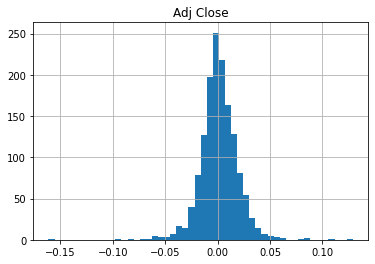

         Adj Close
count  1454.000000
mean      0.001442
std       0.018295
min      -0.161417
25%      -0.008009
50%       0.000708
75%       0.011137
max       0.128987


In [5]:
# Диаграмма `daily_pct_c`
daily_pct_change.hist(bins=50)

plt.show()

# Общая статистика
print(daily_pct_change.describe())

Распределение выглядит очень симметрично и нормально распределённым вокруг значения 0,00. Для получения других значений статистики используется функция description (). В результате видно, что среднее значение немного больше нуля, а стандартное отклонение составляет практически 0,02.

**Кумулятивная доходность**

Кумулятивная дневная прибыль полезна для определения стоимости инвестиций через определенные промежуток времени. Ее можно рассчитать, как приводится в коде ниже.

In [6]:
# Кумулютивная дневная доходность
cum_daily_return = (1 + daily_pct_change).cumprod()

print(cum_daily_return.tail())

            Adj Close
Date                 
2021-10-11   6.651933
2021-10-12   6.504360
2021-10-13   6.531676
2021-10-14   6.467939
2021-10-15   6.371218


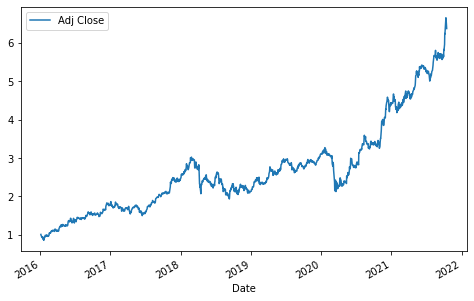

In [12]:
# Построение кумулятивной дневной доходности
cum_daily_return.plot(figsize=(8,5))

plt.show()

Можно пересчитать доходность в месячном периоде:

In [13]:
# Месячная кумулятивная доходность
cum_monthly_return = cum_daily_return.resample("M").mean()

print(cum_monthly_return.tail())

            Adj Close
Date                 
2021-06-30   5.354601
2021-07-31   5.182009
2021-08-31   5.584808
2021-09-30   5.653339
2021-10-31   6.318509


Знание того, как рассчитать доходность, является ценным при анализе акции. Но еще большую ценность оно представляет при сравнении с другими акциями.

Возьмем некоторые акции (выбор их совершенно случайный) и построим их диаграмму.

[*********************100%***********************]  7 of 7 completed


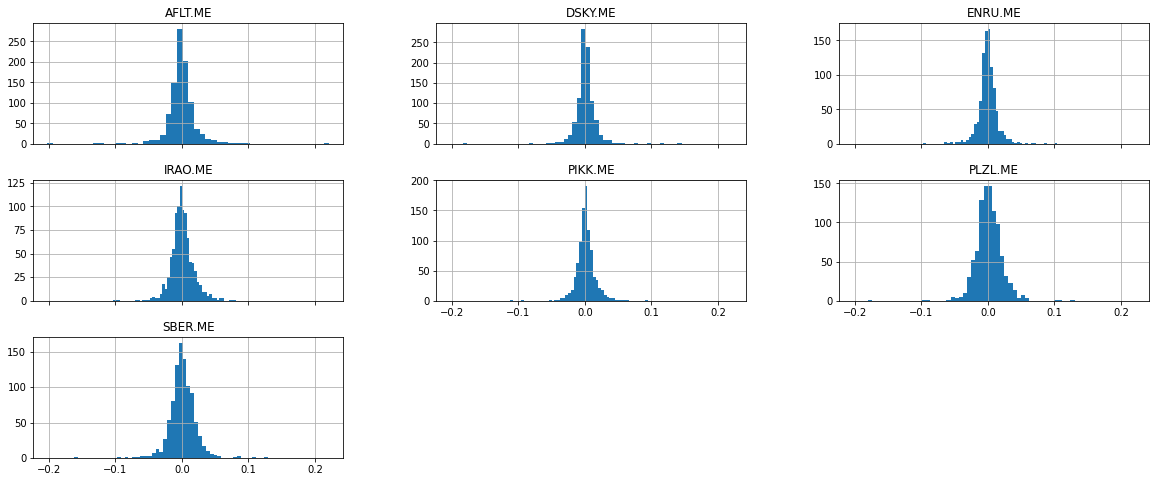

In [14]:
ticker = ['AFLT.ME','DSKY.ME','IRAO.ME','PIKK.ME', 'PLZL.ME','SBER.ME','ENRU.ME']

stock = yf.download(ticker,'2018-01-01')

# Дневная доходность в `daily_close_px`
daily_pct_change = stock['Adj Close'].pct_change()

# Распределение
daily_pct_change.hist(bins=50, sharex=True, figsize=(20,8))

plt.show()

Еще один полезный график —матрица рассеяния. Ее можно легко построить при помощи функции scatter_matrix (), входящей в библиотеку pandas. В качестве аргументов используется daily_pct_change и устанавливается параметр Ядерной оценки плотности — Kernel Density Estimation. Кроме того, можно установить прозрачность с помощью параметра alpha и размер графика с помощью параметра figsize.

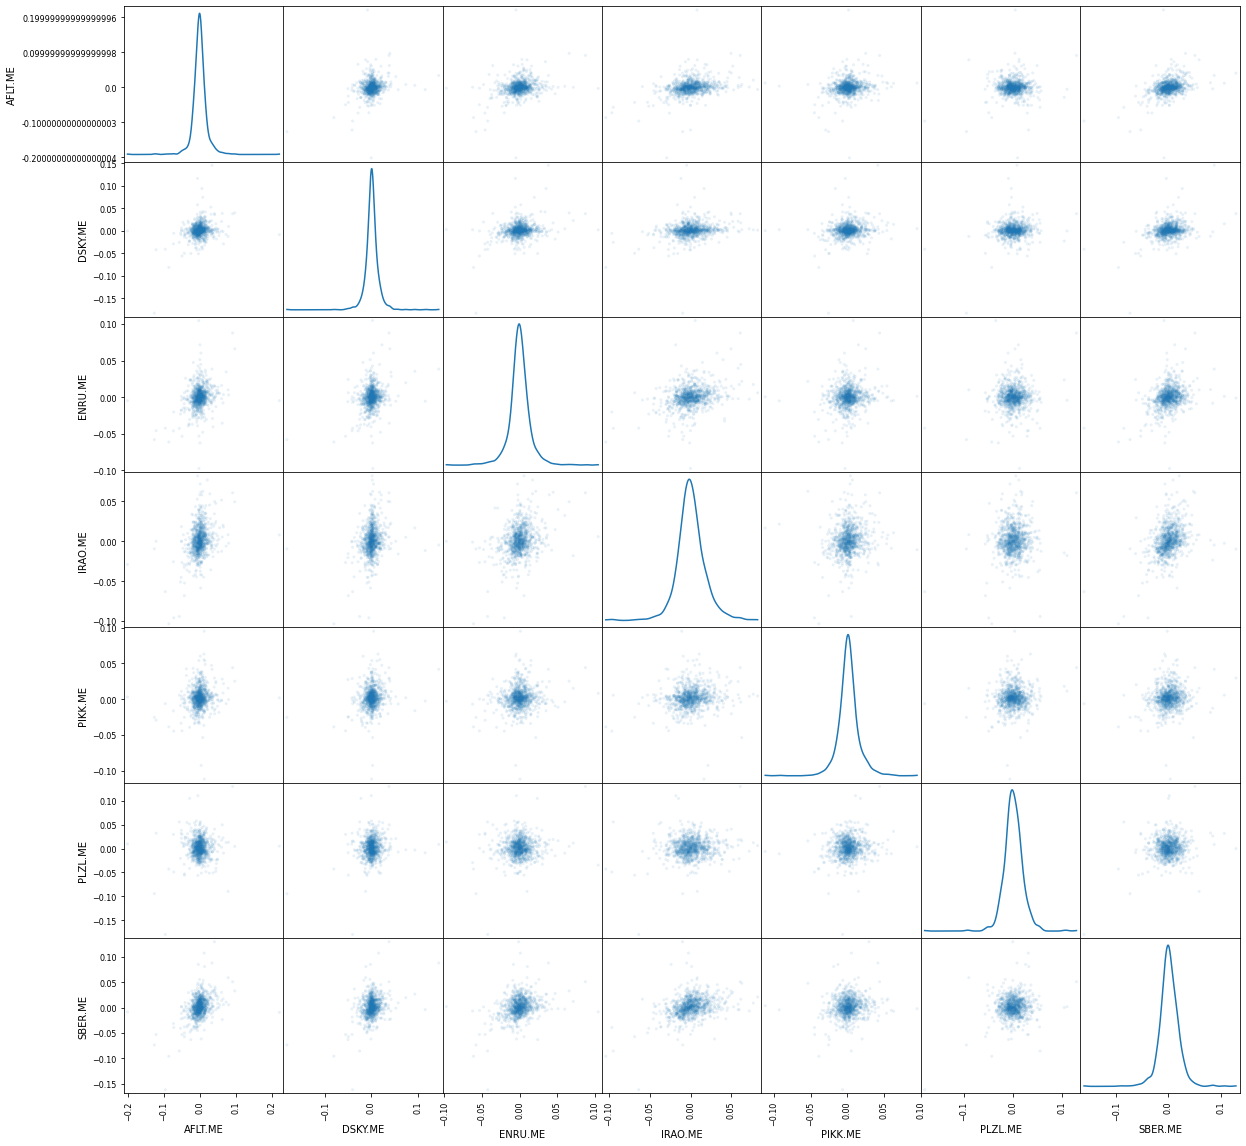

In [15]:
from pandas.plotting import scatter_matrix

# Матрица рассеивания `daily_pct_change`  
scatter_matrix(daily_pct_change, diagonal='kde', alpha=0.1,figsize=(20,20))

plt.show()